In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

The following function checks for the xlsx (Excel) files in the data folder. Each spreadsheet should have a CM, EM and QM sheet with the same structure. Each sheet is then stored as a pandas dataframe with the name of the file followed by the sheet name, e.g. ChatGPT 5 responses_CM is the pandas dataframe with the Classical mechanics solutions stored in it. Each dataframe is then stored in a dictionary

In [2]:
def load_excel_sheets(data_dir='data'):
    # Find the Excel file in the data directory
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"The directory '{data_dir}' does not exist.")

    files = [f for f in os.listdir(data_dir) if f.endswith(".xlsx")]
    if not files:
        raise FileNotFoundError(f"No Excel file found in the '{data_dir}' directory.")

    dataframes = {}
    
    for file_name in files:
        file_path = os.path.join(data_dir, file_name)
        # Load the Excel file
        xls = pd.ExcelFile(file_path)
        print(f"Loaded Excel file: {file_path}")
        
        # Get filename without extension for the key
        file_base_name = os.path.splitext(file_name)[0]

        for sheet_name in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet_name)
            # Clean column names by stripping whitespace
            df.columns = df.columns.str.strip()
            
            # Create unique key: filename_sheetname
            key = f"{file_base_name}_{sheet_name}"
            dataframes[key] = df
            print(f"  Loaded sheet: {sheet_name} as key: {key}")
    
    return dataframes

# Load all sheets into a dictionary of DataFrames
dfs = load_excel_sheets()

# Example: Display the keys
print("\nLoaded dataframe keys:", list(dfs.keys()))

Loaded Excel file: data\ChatGPT 4o diagram.xlsx
  Loaded sheet: CM as key: ChatGPT 4o diagram_CM
  Loaded sheet: EM as key: ChatGPT 4o diagram_EM
  Loaded sheet: QM as key: ChatGPT 4o diagram_QM
Loaded Excel file: data\ChatGPT 5.1 diagram.xlsx
  Loaded sheet: CM as key: ChatGPT 5.1 diagram_CM
  Loaded sheet: EM as key: ChatGPT 5.1 diagram_EM
  Loaded sheet: QM as key: ChatGPT 5.1 diagram_QM
Loaded Excel file: data\ChatGPT 5.1 nondiagram.xlsx
  Loaded sheet: CM as key: ChatGPT 5.1 nondiagram_CM
  Loaded sheet: EM as key: ChatGPT 5.1 nondiagram_EM
  Loaded sheet: QM as key: ChatGPT 5.1 nondiagram_QM
Loaded Excel file: data\Gemini 2.5 diagram.xlsx
  Loaded sheet: CM as key: Gemini 2.5 diagram_CM
  Loaded sheet: EM as key: Gemini 2.5 diagram_EM
  Loaded sheet: QM as key: Gemini 2.5 diagram_QM
Loaded Excel file: data\Gemini 3 diagram.xlsx
  Loaded sheet: CM as key: Gemini 3 diagram_CM
  Loaded sheet: EM as key: Gemini 3 diagram_EM
  Loaded sheet: QM as key: Gemini 3 diagram_QM

Loaded dataf

In [3]:
# Calculate the mean solution, standard deviation, and mean percentage mark for each dataframe
for key, df in dfs.items():
    # Identify the solution columns (assuming 'Solution 1', 'Solution 2', 'Solution 3')
    # We use a case-insensitive check to be robust
    solution_cols = [col for col in df.columns if col.lower() in ['solution 1', 'solution 2', 'solution 3']]
    
    if len(solution_cols) == 3:
        df['mean solution'] = df[solution_cols].mean(axis=1)
        df['std solution'] = df[solution_cols].std(axis=1)
        print(f"Added 'mean solution' and 'std solution' to {key}")
        
        # Calculate mean percentage mark
        # Check for 'Available marks' column (case-insensitive)
        available_marks_col = next((col for col in df.columns if col.lower() == 'available marks'), None)
        
        if available_marks_col:
            df['mean percentage mark'] = (df['mean solution'] / df[available_marks_col]) * 100
            print(f"Added 'mean percentage mark' to {key}")
        else:
            print(f"Skipped 'mean percentage mark' for {key}: 'Available marks' column not found")
            
    else:
        print(f"Skipped {key}: Expected 3 solution columns, found {len(solution_cols)} ({solution_cols})")

# Verify the result with the first dataframe
if dfs:
    first_key = list(dfs.keys())[0]
    print(f"\nFirst 5 rows of {first_key}:")
    display(dfs[first_key].head())

Added 'mean solution' and 'std solution' to ChatGPT 4o diagram_CM
Added 'mean percentage mark' to ChatGPT 4o diagram_CM
Added 'mean solution' and 'std solution' to ChatGPT 4o diagram_EM
Added 'mean percentage mark' to ChatGPT 4o diagram_EM
Added 'mean solution' and 'std solution' to ChatGPT 4o diagram_QM
Added 'mean percentage mark' to ChatGPT 4o diagram_QM
Added 'mean solution' and 'std solution' to ChatGPT 5.1 diagram_CM
Added 'mean percentage mark' to ChatGPT 5.1 diagram_CM
Added 'mean solution' and 'std solution' to ChatGPT 5.1 diagram_EM
Added 'mean percentage mark' to ChatGPT 5.1 diagram_EM
Added 'mean solution' and 'std solution' to ChatGPT 5.1 diagram_QM
Added 'mean percentage mark' to ChatGPT 5.1 diagram_QM
Added 'mean solution' and 'std solution' to ChatGPT 5.1 nondiagram_CM
Added 'mean percentage mark' to ChatGPT 5.1 nondiagram_CM
Added 'mean solution' and 'std solution' to ChatGPT 5.1 nondiagram_EM
Added 'mean percentage mark' to ChatGPT 5.1 nondiagram_EM
Added 'mean soluti

,Question Number,Available Marks,Solution 1,Solution 2,Solution 3,mean solution,std solution,mean percentage mark
0,1,5,4,5,3,4.000000,1.000000,80.000000
1,2,6,6,1,1,2.666667,2.886751,44.444444
2,3,9,9,9,9,9.000000,0.000000,100.000000
3,4,10,10,10,10,10.000000,0.000000,100.000000
4,5,10,8,5,7,6.666667,1.527525,66.666667


In [4]:
def split_dataframes_by_type(dfs):
    diagrams_dfs = {}
    nondiagrams_dfs = {}
    
    for key, df in dfs.items():
        # Check if 'diagram' is in the key (case-insensitive) to categorize
        if 'nondiagram' in key.lower():
            nondiagrams_dfs[key] = df
        else:
            diagrams_dfs[key] = df
            
    return diagrams_dfs, nondiagrams_dfs

# Split the dataframes
diagrams_dfs, nondiagrams_dfs = split_dataframes_by_type(dfs)

print(f"Diagrams DataFrames: {list(diagrams_dfs.keys())}")
print(f"Non-Diagrams DataFrames: {list(nondiagrams_dfs.keys())}")

Diagrams DataFrames: ['ChatGPT 4o diagram_CM', 'ChatGPT 4o diagram_EM', 'ChatGPT 4o diagram_QM', 'ChatGPT 5.1 diagram_CM', 'ChatGPT 5.1 diagram_EM', 'ChatGPT 5.1 diagram_QM', 'Gemini 2.5 diagram_CM', 'Gemini 2.5 diagram_EM', 'Gemini 2.5 diagram_QM', 'Gemini 3 diagram_CM', 'Gemini 3 diagram_EM', 'Gemini 3 diagram_QM']
Non-Diagrams DataFrames: ['ChatGPT 5.1 nondiagram_CM', 'ChatGPT 5.1 nondiagram_EM', 'ChatGPT 5.1 nondiagram_QM']


In [5]:
def calculate_sheet_stats(dfs):
    sheet_stats = {}
    for key, df in dfs.items():
        stats = {}
        
        # Check for 'Available marks' column (case-insensitive)
        available_marks_col = next((col for col in df.columns if col.lower() == 'available marks'), None)
        
        # Calculate mean percentage mark using Total Score / Total Available
        # This avoids skewing by questions with few marks (e.g. 1/1 = 100%)
        if available_marks_col and 'mean solution' in df.columns:
            # Ensure numeric types
            df['mean solution'] = pd.to_numeric(df['mean solution'], errors='coerce')
            df[available_marks_col] = pd.to_numeric(df[available_marks_col], errors='coerce')
            
            # Filter valid rows
            valid_mask = (df[available_marks_col] > 0) & (df['mean solution'].notna())
            valid_rows = df[valid_mask]
            
            total_solution = valid_rows['mean solution'].sum()
            total_available = valid_rows[available_marks_col].sum()
            
            if total_available > 0:
                stats['mean_percentage'] = (total_solution / total_available) * 100
            else:
                stats['mean_percentage'] = 0
        elif 'mean percentage mark' in df.columns:
            stats['mean_percentage'] = df['mean percentage mark'].mean()
        else:
            print(f"Warning: 'mean percentage mark' column not found in {key}")
            stats['mean_percentage'] = None
            
        # Calculate mean of 'std solution'
        if 'std solution' in df.columns:
            stats['mean_std'] = df['std solution'].mean()
        else:
            print(f"Warning: 'std solution' column not found in {key}")
            stats['mean_std'] = None
            
        sheet_stats[key] = stats
    return sheet_stats

# Calculate stats for all sheets
sheet_stats = calculate_sheet_stats(dfs)

# print("\nStatistics per Sheet:")
# for key, val in sheet_stats.items():
#     mean_pct = val['mean_percentage']
#     mean_std = val['mean_std']
    
#     pct_str = f"{mean_pct:.2f}%" if mean_pct is not None else "N/A"
#     std_str = f"{mean_std:.2f}" if mean_std is not None else "N/A"
    
#     print(f"{key}: Mean Percentage = {pct_str}, Mean Std Dev = {std_str}")

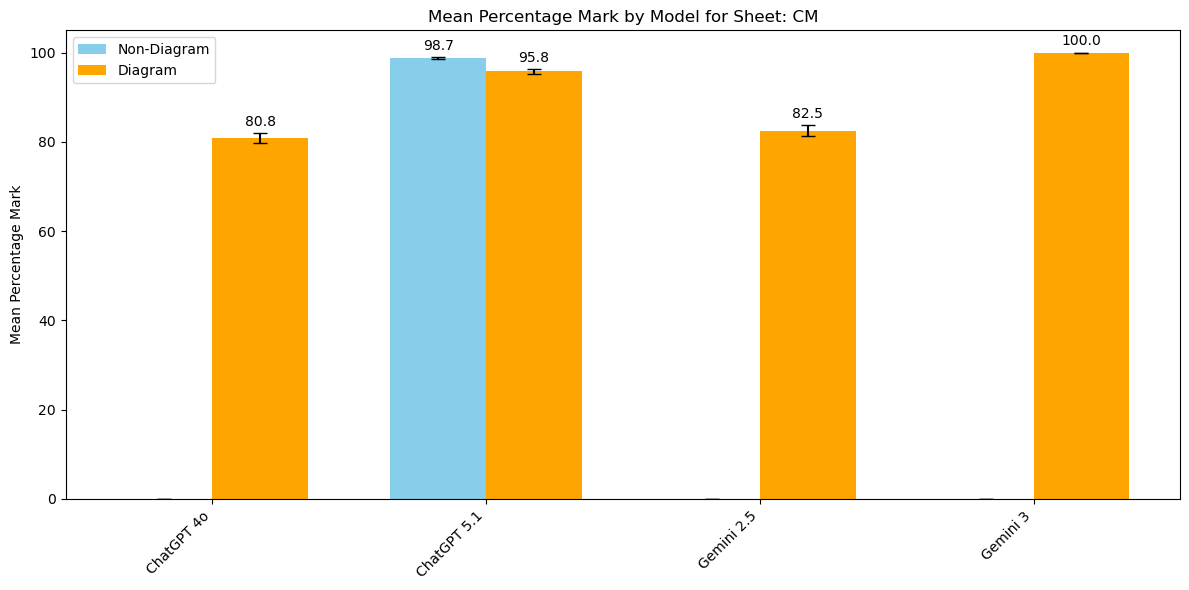

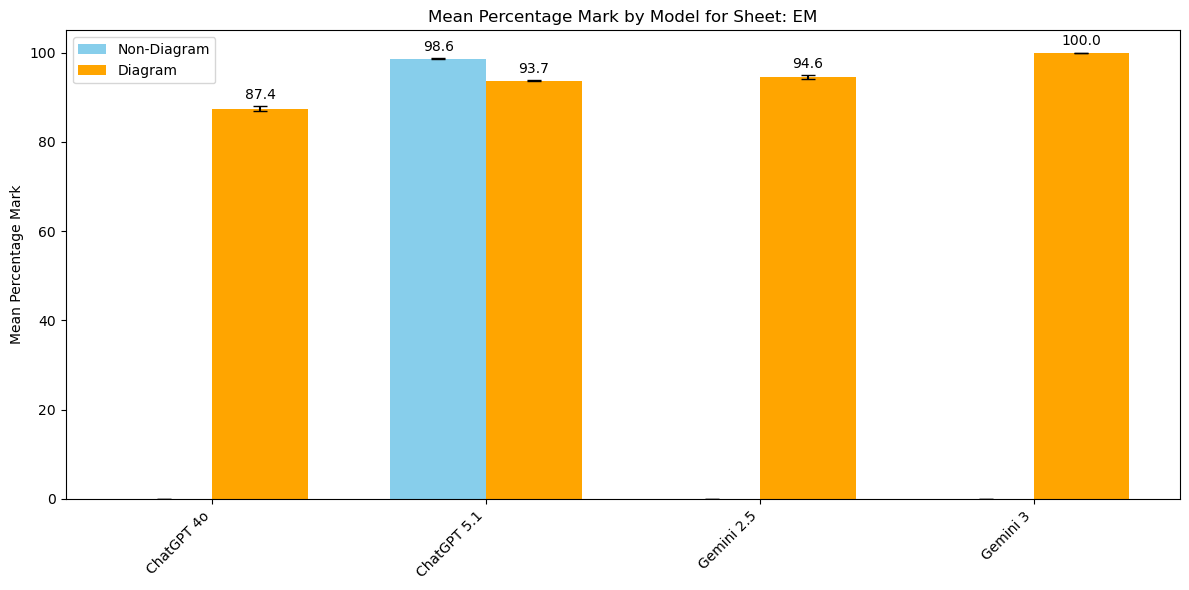

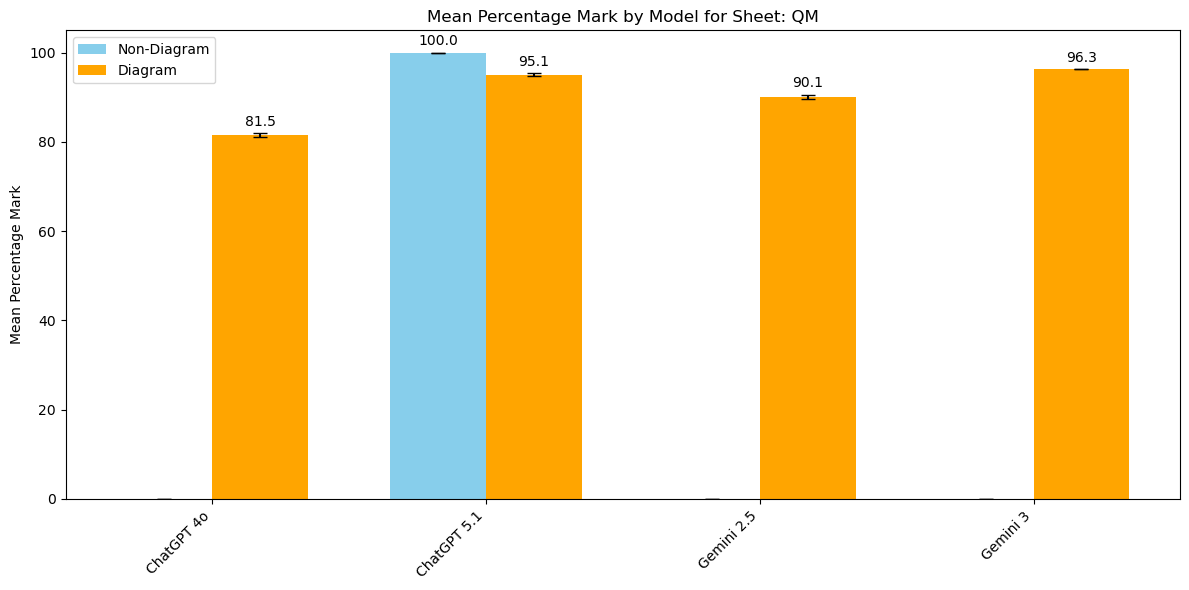

In [6]:
def plot_sheet_comparisons(diagrams_stats, nondiagrams_stats):
    import matplotlib.pyplot as plt
    import numpy as np
    import re

    # Group data by Sheet Name, then by Model Name
    # Structure: { 'Sheet Name': { 'Model Name': {'Diagram': (mean, std), 'Non-Diagram': (mean, std)} } }
    sheets_data = {}
    
    # Helper to process stats dictionary
    def process_stats(stats_dict, type_label):
        for key, stats in stats_dict.items():
            if stats['mean_percentage'] is None:
                continue
                
            # Split key to get filename and sheetname
            try:
                file_base, sheet_name = key.rsplit('_', 1)
            except ValueError:
                print(f"Skipping key with unexpected format: {key}")
                continue
            
            # Normalize model name
            # Remove 'diagram' and 'nondiagram' (case insensitive) and trim whitespace
            model_name = re.sub(r'\s*nondiagram\s*', '', file_base, flags=re.IGNORECASE)
            model_name = re.sub(r'\s*diagram\s*', '', model_name, flags=re.IGNORECASE).strip()
            
            # Also handle potential extra spaces or variations if needed
            model_name = model_name.strip()

            if sheet_name not in sheets_data:
                sheets_data[sheet_name] = {}
            
            if model_name not in sheets_data[sheet_name]:
                sheets_data[sheet_name][model_name] = {}
            
            sheets_data[sheet_name][model_name][type_label] = stats

    # Process both dictionaries
    process_stats(diagrams_stats, 'Diagram')
    process_stats(nondiagrams_stats, 'Non-Diagram')
        
    # Plot for each Sheet (CM, EM, QM)
    for sheet_name, models in sheets_data.items():
        # Prepare data for plotting
        model_names = sorted(list(models.keys()))
        
        means_diagram = []
        stds_diagram = []
        means_nondiagram = []
        stds_nondiagram = []
        
        for model in model_names:
            # Get Diagram stats
            d_stats = models[model].get('Diagram')
            if d_stats:
                means_diagram.append(d_stats['mean_percentage'])
                stds_diagram.append(d_stats['mean_std'])
            else:
                means_diagram.append(0)
                stds_diagram.append(0)
                
            # Get Non-Diagram stats
            nd_stats = models[model].get('Non-Diagram')
            if nd_stats:
                means_nondiagram.append(nd_stats['mean_percentage'])
                stds_nondiagram.append(nd_stats['mean_std'])
            else:
                means_nondiagram.append(0)
                stds_nondiagram.append(0)
        
        # Plotting
        x = np.arange(len(model_names))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot Non-Diagram bars
        rects1 = ax.bar(x - width/2, means_nondiagram, width, yerr=stds_nondiagram, label='Non-Diagram', capsize=5, color='skyblue')
        
        # Plot Diagram bars
        rects2 = ax.bar(x + width/2, means_diagram, width, yerr=stds_diagram, label='Diagram', capsize=5, color='orange')
        
        ax.set_ylabel('Mean Percentage Mark')
        ax.set_title(f'Mean Percentage Mark by Model for Sheet: {sheet_name}')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.legend()
        
        # Add labels
        ax.bar_label(rects1, padding=3, fmt='%.1f', labels=[f'{v:.1f}' if v > 0 else '' for v in means_nondiagram])
        ax.bar_label(rects2, padding=3, fmt='%.1f', labels=[f'{v:.1f}' if v > 0 else '' for v in means_diagram])
        
        plt.tight_layout()
        plt.show()

# Calculate stats for separated dataframes
diagrams_stats = calculate_sheet_stats(diagrams_dfs)
nondiagrams_stats = calculate_sheet_stats(nondiagrams_dfs)

# Plot the comparisons using the separated stats
plot_sheet_comparisons(diagrams_stats, nondiagrams_stats)

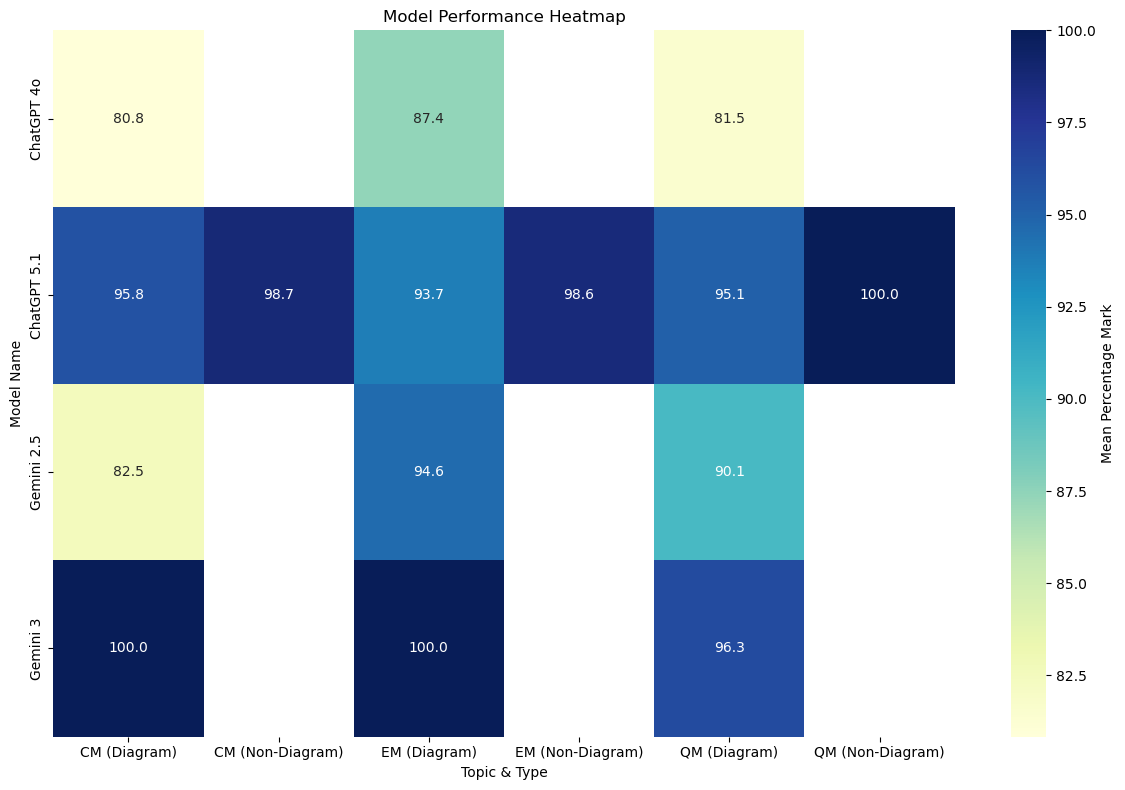

In [7]:
def plot_performance_heatmap(diagrams_stats, nondiagrams_stats):
    

    # Prepare data for heatmap
    # Rows: Model Names
    # Columns: Sheet Name + Type (e.g., "CM (Diagram)", "CM (Non-Diagram)")
    
    data = []
    
    # Helper to process stats dictionary
    def process_stats(stats_dict, type_label):
        for key, stats in stats_dict.items():
            if stats['mean_percentage'] is None:
                continue
                
            # Split key to get filename and sheetname
            try:
                file_base, sheet_name = key.rsplit('_', 1)
            except ValueError:
                continue
            
            # Normalize model name
            model_name = re.sub(r'\s*nondiagram\s*', '', file_base, flags=re.IGNORECASE)
            model_name = re.sub(r'\s*diagram\s*', '', model_name, flags=re.IGNORECASE).strip()
            model_name = model_name.strip()
            
            column_name = f"{sheet_name} ({type_label})"
            
            data.append({
                'Model': model_name,
                'Category': column_name,
                'Score': stats['mean_percentage']
            })

    process_stats(diagrams_stats, 'Diagram')
    process_stats(nondiagrams_stats, 'Non-Diagram')
    
    if not data:
        print("No data available for heatmap.")
        return

    # Create DataFrame
    df_heatmap = pd.DataFrame(data)
    
    # Pivot table for heatmap format
    heatmap_data = df_heatmap.pivot_table(index='Model', columns='Category', values='Score')
    
    # Sort columns to keep Diagram/Non-Diagram pairs together if possible, or just alphabetically
    # Custom sort could be applied here if needed
    heatmap_data = heatmap_data.sort_index(axis=1)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Mean Percentage Mark'})
    plt.title('Model Performance Heatmap')
    plt.ylabel('Model Name')
    plt.xlabel('Topic & Type')
    plt.tight_layout()
    plt.show()

# Plot the heatmap
plot_performance_heatmap(diagrams_stats, nondiagrams_stats)